# Classification

## Team Name
>### Sigma  

## Team Member
>### 조현윤, 이상협, 정하연  

## Objective
> ### in search of better methods of using this behavioral data to predict which individuals they should approach—and even when and how to approach them.
> ### to create a classification algorithm that accurately identifies which customers have the most potential business value for Red Hat based on their characteristics and activities.
> ### to predict the potential business value of a person who has performed a specific activity.

## Evaluation
> ### valuated on area under the ROC curve between the predicted and the observed outcome.

## Submission File
> ### For each activity_id in the test set, you must predict a probability for the 'outcome' variable, represented by a number between 0 and 1.
~~~~
activity_id,outcome
act1_1,0
act1_100006,0
act1_100050,0
~~~~

## Data
> ### uses two separate data files that may be joined together to create a single, unified data table: a people file and an activity file.
> ### The people file contains all of the unique people (and the corresponding characteristics) that have performed activities over time. Each row in the people file represents a unique person. Each person has a unique people_id.
> ### The activity file contains all of the unique activities (and the corresponding activity characteristics) that each person has performed over time. Each row in the activity file represents a unique activity performed by a person on a certain date. Each activity has a unique activity_id.
> ### The activity file contains several different categories of activities. 
>> Type 1 activities are different from type 2-7 activities because there are more known characteristics associated with type 1 activities (nine in total) than type 2-7 activities (which have only one associated characteristic).
> ### To develop a predictive model with this data, you will likely need to join the files together into a single data set. The two files can be joined together using person_id as the common key. All variables are categorical, with the exception of 'char_38' in the people file, which is a continuous numerical variable.

## Reference 
[kaggel Predicting Red Hat Business Value](https://www.kaggle.com/c/predicting-red-hat-business-value)

### Load Python Package

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from datetime import datetime
from datetime import date
import seaborn as sns
import statsmodels.api as sm
import statsmodels.stats.api as sms
import statsmodels.stats.stattools as stools
import scipy as sp
%matplotlib inline

In [2]:
import xgboost

/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [3]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

In [4]:
from sklearn.tree import DecisionTreeClassifier

In [5]:
from sklearn.metrics import *

In [6]:
from sklearn.ensemble import VotingClassifier

In [7]:
from sklearn.ensemble import GradientBoostingClassifier

In [8]:
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier

In [9]:
from sklearn.linear_model import LogisticRegression

In [10]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

In [11]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [12]:
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier


In [13]:
from sklearn.preprocessing import LabelEncoder

In [14]:
cv =KFold(10)

## Exploratory Data Analysis (EDA )¶

## Load Data Set

In [15]:
# activity data set
act_Train = pd.read_csv('./data/act_train.csv')
act_Test = pd.read_csv('./data/act_test.csv')
# people data set
people = pd.read_csv('./data/people.csv')

### Split people data set wether train data set or test data set

In [16]:
idx_train =list(act_Train['people_id'].value_counts().index)
idx_test =list(act_Test['people_id'].value_counts().index)

In [17]:
train_people = people.loc[people['people_id'].isin(idx_train)]
test_people = people.loc[people['people_id'].isin(idx_test)]

In [18]:
train_people.to_csv('./data/act_train_people.csv',index=False)
test_people.to_csv('./data/act_test_people.csv',index=False)

In [19]:
print('Number of active people: {}'.format(act_Train['people_id'].nunique()))

Number of active people: 151295


In [20]:
print('Number of active people: {}'.format(act_Test['people_id'].nunique()))

Number of active people: 37823


In [ ]:
trainMerge = pd.merge(act_Train,people, on='people_id')
trainMerge.tail()

,people_id,activity_id,date_x,activity_category,char_1_x,char_2_x,char_3_x,char_4_x,char_5_x,char_6_x,...,char_29,char_30,char_31,char_32,char_33,char_34,char_35,char_36,char_37,char_38
2197286,ppl_99994,act2_4668076,2023-06-16,type 4,NaN,NaN,NaN,NaN,NaN,NaN,...,True,True,True,True,False,True,True,True,True,95
2197287,ppl_99994,act2_4743548,2023-03-30,type 4,NaN,NaN,NaN,NaN,NaN,NaN,...,True,True,True,True,False,True,True,True,True,95
2197288,ppl_99994,act2_536973,2023-01-19,type 2,NaN,NaN,NaN,NaN,NaN,NaN,...,True,True,True,True,False,True,True,True,True,95
2197289,ppl_99994,act2_688656,2023-05-02,type 4,NaN,NaN,NaN,NaN,NaN,NaN,...,True,True,True,True,False,True,True,True,True,95
2197290,ppl_99994,act2_715089,2023-06-15,type 2,NaN,NaN,NaN,NaN,NaN,NaN,...,True,True,True,True,False,True,True,True,True,95


In [ ]:
trainMerge.to_csv('./data/train_merge.csv',index=False)

In [ ]:
testMerge = pd.merge(act_Test,people, on='people_id')
testMerge.tail()

In [ ]:
testMerge.to_csv('./data/test_merge.csv',index=False)

In [ ]:
dfx = act_Train.groupby(['people_id','outcome']).size().unstack()
dfx = dfx.fillna(0).astype(int)

In [ ]:
only1 = dfx[(dfx[0]==0) & (dfx[1]!=0)]
only0 = dfx[(dfx[0]!=0) & (dfx[1]==0)]
mix_0or1 = dfx[(dfx[0]!=0) & (dfx[1]!=0)]

In [ ]:
print (len(only1.index),len(only0.index),len(mix_0or1))

In [ ]:
train_People = pd.merge(train_people, dfx, left_on = 'people_id',right_index = True)

In [ ]:
train_People.rename(columns={0:'outcome_0',1:'outcome_1'}, inplace = True)

In [ ]:
def ax(x):
    if x['outcome_0'] !=0 and x['outcome_1'] ==0:
        return 0
    elif x['outcome_0'] ==0 and x['outcome_1'] !=0:
        return 1
    else:
        return 2

In [ ]:
train_People.head()

In [ ]:
train_People['result'] = train_People.apply(ax, axis = 1)

In [ ]:
train_People.tail()

In [ ]:
train_People.info()

In [ ]:
for idx in trainMerge.columns:
    if 'type 0' in list(trainMerge[idx].unique()):
        print (idx, 'type 0')
    else:pass

In [ ]:
trainMerge.info()

In [ ]:
trainMerge.head()

In [ ]:
for idx in trainMerge.columns:
    print (idx)
    if idx not in ['people_id', 'activity_id', 'date_x','date_y', 'char_38', 'outcome']:
        if trainMerge[idx].dtype == 'object':
            trainMerge.fillna('type 0', inplace = True)
            trainMerge[idx] = trainMerge[idx].apply(lambda x:x.split(' ')[1]).astype(np.int32)
        elif trainMerge[idx].dtype == 'bool':
            trainMerge[idx] = trainMerge[idx].astype(np.int8)

In [ ]:
trainMerge['date_x'] = pd.to_datetime(trainMerge['date_x'])
trainMerge['date_y'] = pd.to_datetime(trainMerge['date_y'])

In [ ]:
trainMerge['year_x'] = trainMerge['date_x'].dt.year
trainMerge['month_x'] = trainMerge['date_x'].dt.month
trainMerge['day_x'] = trainMerge['date_x'].dt.day
trainMerge['weekday_x'] = trainMerge['date_x'].dt.weekday
trainMerge['weekend_x'] = ((trainMerge.weekday_x == 0) | (trainMerge.weekday_x == 6)).astype(int)
trainMerge = trainMerge.drop('date_x', axis = 1)
    
trainMerge['year_y'] = trainMerge['date_y'].dt.year
trainMerge['month_y'] = trainMerge['date_y'].dt.month
trainMerge['day_y'] = trainMerge['date_y'].dt.day
trainMerge['weekday_y'] = trainMerge['date_y'].dt.weekday
trainMerge['weekend_y'] = ((trainMerge.weekday_y == 0) | (trainMerge.weekday_y == 6)).astype(int)
trainMerge = trainMerge.drop('date_y', axis = 1)

In [ ]:
trainMerge.tail()

In [ ]:
mergeX = trainMerge.drop(['people_id','activity_id','outcome'],axis = 1)
mergey = trainMerge['outcome']

In [ ]:
for idx in testMerge.columns:
    print (idx)
    if idx not in ['people_id', 'activity_id', 'date_x','date_y', 'char_38', 'outcome']:
        if testMerge[idx].dtype == 'object':
            testMerge.fillna('type 0', inplace = True)
            testMerge[idx] = testMerge[idx].apply(lambda x:x.split(' ')[1]).astype(np.int32)
        elif testMerge[idx].dtype == 'bool':
            testMerge[idx] = testMerge[idx].astype(np.int8)

In [ ]:
testMerge['date_x'] = pd.to_datetime(testMerge['date_x'])
testMerge['date_y'] = pd.to_datetime(testMerge['date_y'])

In [ ]:
testMerge['year_x'] = testMerge['date_x'].dt.year
testMerge['month_x'] = testMerge['date_x'].dt.month
testMerge['day_x'] = testMerge['date_x'].dt.day
testMerge['weekday_x'] = testMerge['date_x'].dt.weekday
testMerge['weekend_x'] = ((testMerge.weekday_x == 0) | (testMerge.weekday_x == 6)).astype(int)
testMerge = testMerge.drop('date_x', axis = 1)
    
testMerge['year_y'] = testMerge['date_y'].dt.year
testMerge['month_y'] = testMerge['date_y'].dt.month
testMerge['day_y'] = testMerge['date_y'].dt.day
testMerge['weekday_y'] = testMerge['date_y'].dt.weekday
testMerge['weekend_y'] = ((testMerge.weekday_y == 0) | (testMerge.weekday_y == 6)).astype(int)
testMerge = testMerge.drop('date_y', axis = 1)

In [ ]:
testX = testMerge.drop(['people_id','activity_id'],axis = 1)
#testy = trainMerge['outcome']

In [ ]:
import time
import xgboost as xgb
from sklearn.cross_validation import train_test_split

In [105]:
def run(train, test, random_state=0):
    eta = 1.3
    max_depth = 3
    subsample = 0.8
    colsample_bytree = 0.8
    start_time = time.time()
    params ={
        "objective": "binary:logistic",
        "booster" : "gbtree",
        "eval_metric": "auc",
        "max_depth" : max_depth,
        "subsample": subsample,
        "colsample_bytree": colsample_bytree,
        "silent":1,
        "seed": random_state
    }
    num_boost_round = 2
    early_stopping_rounds = 10
    test_size = 0.1
    X_train, X_valid = train_test_split(train, test_size=test_size, random_state=random_state)
    y_train = X_train['outcome']
    y_valid = X_valid['outcome']
    X_train = X_train.drop(['people_id','activity_id','outcome'],axis = 1)
    X_valid = X_valid.drop(['people_id','activity_id','outcome'], axis = 1)
    dtrain = xgb.DMatrix(X_train, y_train)
    dvalid = xgb.DMatrix(X_valid, y_valid)
    watchlist = [(dtrain, 'train'), (dvalid, 'eval')]
    gbm = xgb.train(params, dtrain, num_boost_round, evals=watchlist, early_stopping_rounds=early_stopping_rounds, verbose_eval=True)

    check = gbm.predict(xgb.DMatrix(X_valid), ntree_limit=gbm.best_iteration+1)
    score = roc_auc_score(y_valid, check)
    print (score)
    testActivityId = test['activity_id']
    test = test.drop(['people_id','activity_id'],axis = 1)
    test_prediction = gbm.predict(xgb.DMatrix(test), ntree_limit=gbm.best_iteration+1)
    out = pd.concat([testActivityId,pd.DataFrame(test_prediction.round())],axis = 1)
    out.rename({0:'outcome'},axis = 1,inplace = True)
    return out,test_prediction

In [106]:
x = run(trainMerge, testMerge)

[0]	train-auc:0.876135	eval-auc:0.875169
Multiple eval metrics have been passed: 'eval-auc' will be used for early stopping.

Will train until eval-auc hasn't improved in 10 rounds.
[1]	train-auc:0.896448	eval-auc:0.895751
0.895751382685


In [204]:
X_train, X_valid = train_test_split(trainMerge, test_size=0.35, random_state=3)

In [205]:
from keras.utils import np_utils

#X_train.reset_index(inplace = True)
Y_train = np_utils.to_categorical(X_train['outcome'], 2)
X_train = X_train.drop(['people_id','activity_id','outcome'],axis = 1)

#X_valid.reset_index(inplace = True)
Y_valid = np_utils.to_categorical(X_valid['outcome'], 2)
X_valid = X_valid.drop(['people_id','activity_id','outcome'],axis = 1)

In [206]:
print (X_train.shape)
print (X_valid.shape)

(1428239, 60)
(769052, 60)


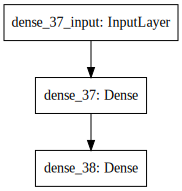

In [207]:
from keras.models import Sequential
from keras.layers.core import Dense
from keras.optimizers import SGD
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

np.random.seed(0)

model = Sequential()
model.add(Dense(10000, input_dim=60, activation="sigmoid"))
model.add(Dense(2, activation="sigmoid"))
model.compile(optimizer=SGD(lr=5), loss='mean_squared_error', metrics=["accuracy"])

SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [212]:
hist = model.fit(X_train.values, Y_train, 
                 epochs=3000, batch_size=15000, 
                 validation_data=(X_valid.values, Y_valid), 
                 verbose=2)

Train on 1428239 samples, validate on 769052 samples
Epoch 1/3000


KeyboardInterrupt: 